Produce some attention maps from the CIFAR 10 model

In [9]:

from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import cv2


import sys
sys.path.append('../vit_pytorch/')
sys.path.append('..')
from vit import ViT
from recorder import Recorder # import the Recorder and instantiate
#from dataloaders import *

from training_loop import ViT_Trainer
from resnet_training_loop import *
from resnet import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from argparse import ArgumentParser, Namespace
import os
import random
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from dataloader import get_CIFAR_data
%matplotlib inline

In [23]:
best_model_path = '/scratch/nsk367/SP21/vit-pytorch/vit_pytorch/lightning_logs/version_6663169/checkpoints/epoch=58.ckpt'


In [24]:
model = ViT_Trainer.load_from_checkpoint(best_model_path)


Files already downloaded and verified


/scratch/nsk367/anaconda3/envs/vit/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [39]:
model.dataset, model.architecture

('cifar10', 'VitBase')

In [26]:
for X_test, y_test in model.test_dataloader():
    break

In [31]:
random_idx = np.random.randint(1, len(X_test), size=9)
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [41]:
model = model.cuda()

In [42]:
predictions = model(X_test.cuda()).argmax(dim=1)

In [43]:
j = 128 # using the jth element from that batch 
attn_mat = model.rec.attn[j].cpu()
img = batch[0]
im = img[j].cpu().numpy().transpose(1,2,0)
attn_mat = torch.mean(attn_mat, dim=1) # average across heads 
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(attn_mat.size(1))
aug_att_mat = attn_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# combines all the different layers which apply attention. 

# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), (model.image_size,model.image_size))[..., np.newaxis]
result = (mask * im.astype("uint8"))

tensor([3, 1, 8, 8, 6, 6, 1, 6, 3, 1, 0, 9, 3, 7, 9, 8, 3, 7, 8, 6, 7, 0, 2, 9,
        2, 4, 4, 2, 9, 6, 6, 5, 6, 3, 9, 1, 4, 9, 9, 5, 9, 6, 5, 6, 0, 9, 3, 9,
        4, 2, 9, 8, 2, 3, 8, 8, 7, 8, 5, 3, 7, 3, 4, 3, 2, 2, 1, 2, 3, 0, 2, 3,
        8, 8, 9, 4, 9, 5, 5, 8, 8, 1, 1, 5, 2, 7, 7, 0, 8, 9, 0, 5, 8, 6, 4, 6,
        6, 0, 0, 7, 2, 5, 6, 3, 1, 1, 3, 6, 8, 5, 4, 0, 2, 2, 9, 3, 0, 4, 3, 7,
        8, 3, 1, 7, 8, 9, 8, 5], device='cuda:0')

In [46]:
def attention_mask(j):
    attn_mat = model.rec.attn[j].cpu()
    img = batch[0]
    im = img[j].cpu().numpy().transpose(1,2,0)
    attn_mat = torch.mean(attn_mat, dim=1) # average across heads 
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(attn_mat.size(1))
    aug_att_mat = attn_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # combines all the different layers which apply attention. 

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), (model.image_size,model.image_size))[..., np.newaxis]
    result = (mask * im.astype("uint8"))
    
    return result, mask

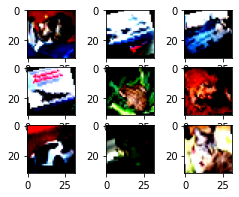

In [58]:
fig, axes = plt.subplots(3, 3, figsize=(4,3))

for idx, ax in enumerate(axes.ravel()):
    img = X_test[idx].detach().cpu().numpy().transpose((1,2,0))
   # ax.set_title(class_name[y_test[idx].item()] + ',' + class_name[predictions[idx].cpu().item()])
    ax.imshow(img)

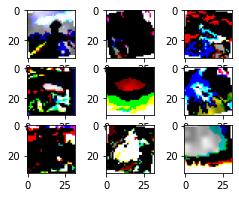

In [57]:
fig, axes = plt.subplots(3, 3, figsize=(4,3))

for idx, ax in enumerate(axes.ravel()):
    img, _ = attention_mask(idx)#X_test[idx].detach().cpu().numpy().transpose((1,2,0))
   # ax.set_title(class_name[y_test[idx].item()] + ',' + class_name[predictions[idx].cpu().item()])
    ax.imshow(img)

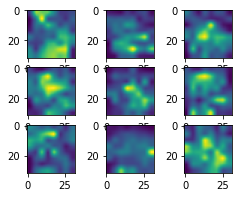

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(4, 3))

for idx, ax in enumerate(axes.ravel()):
    _, img = attention_mask(idx)#X_test[idx].detach().cpu().numpy().transpose((1,2,0))
   # ax.set_title(class_name[y_test[idx].item()] + ',' + class_name[predictions[idx].cpu().item()])
    ax.imshow(img)

In [49]:
predictions[idx].cpu().item()

3